![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [22]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Start coding here
# Use as many cells as you like

In [23]:
weather.head()

date  cloud_cover  sunshine  ...  precipitation  pressure  snow_depth
0  19790101          2.0       7.0  ...            0.4  101900.0         9.0
1  19790102          6.0       1.7  ...            0.0  102530.0         8.0
2  19790103          5.0       0.0  ...            0.0  102050.0         4.0
3  19790104          8.0       0.0  ...            0.0  100840.0         2.0
4  19790105          6.0       2.0  ...            0.0  102250.0         1.0

[5 rows x 10 columns]

In [24]:
y = weather['mean_temp']
x = weather.drop(['mean_temp'], axis=1)
#one hot encoding and label encoding is not required since that isn't any categorical variable

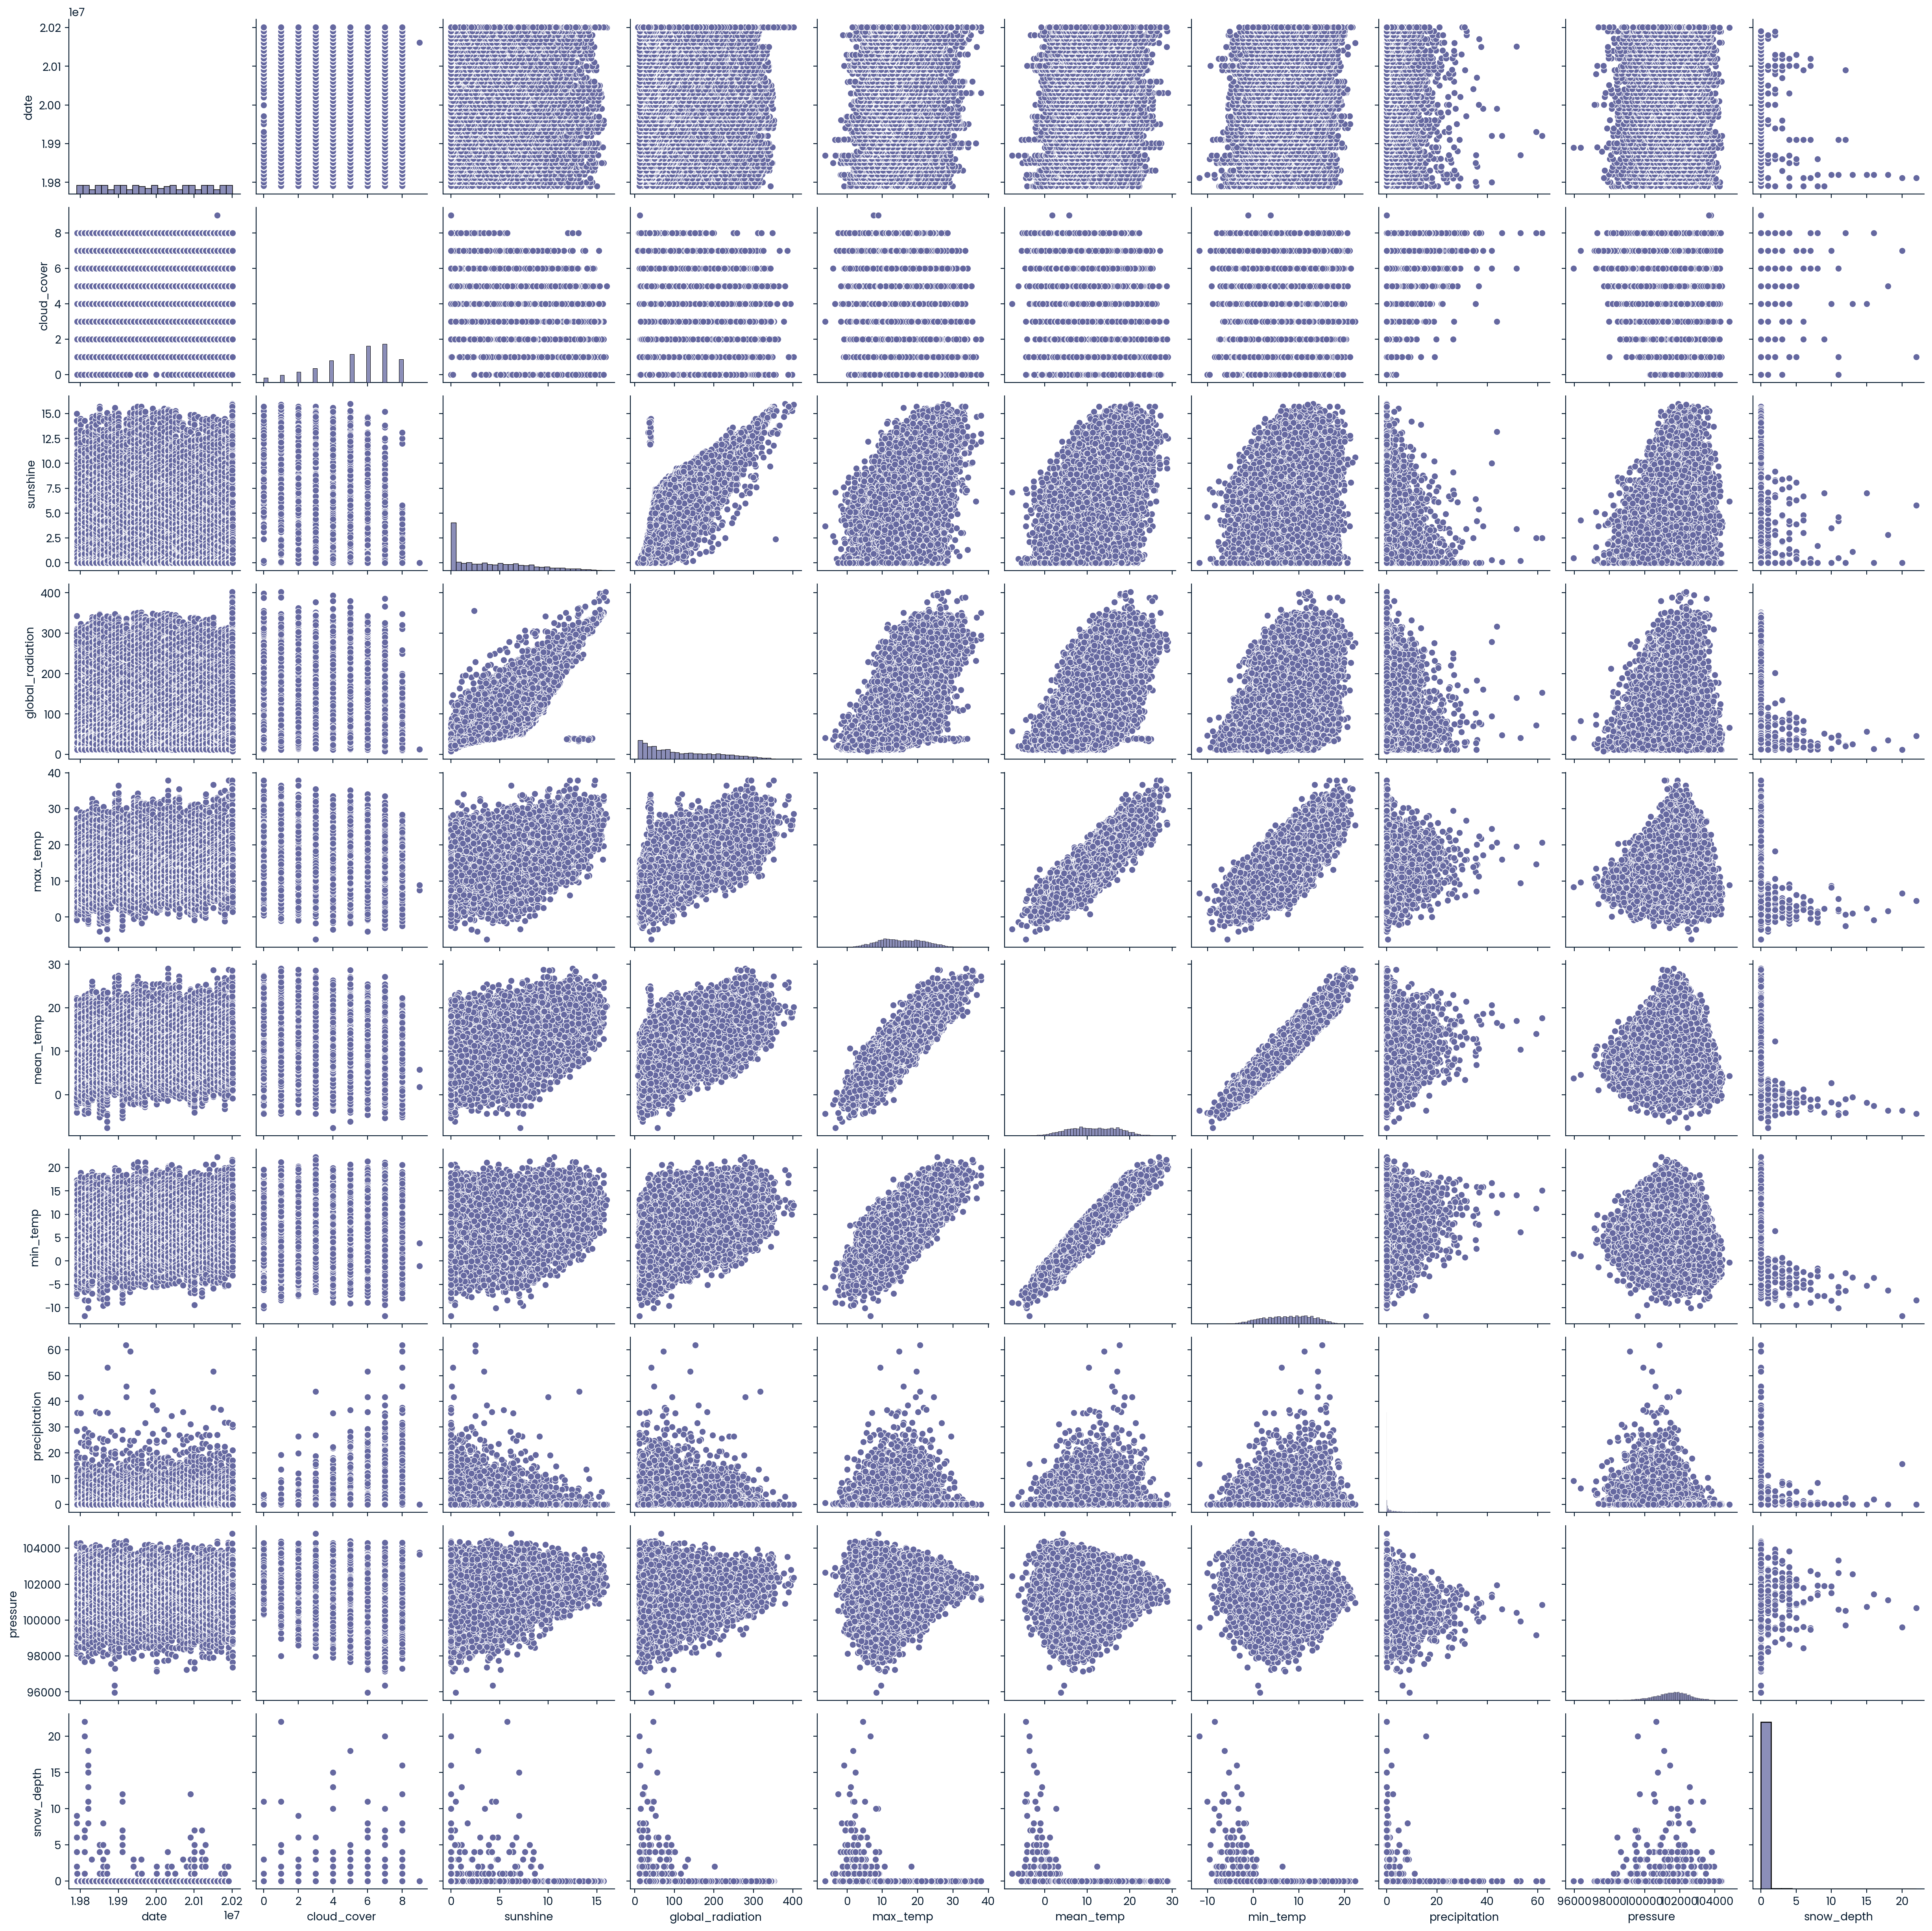

In [25]:
#data visualization
sns.pairplot(weather)
plt.show()

In [26]:
correlation_matrix = weather.corr()

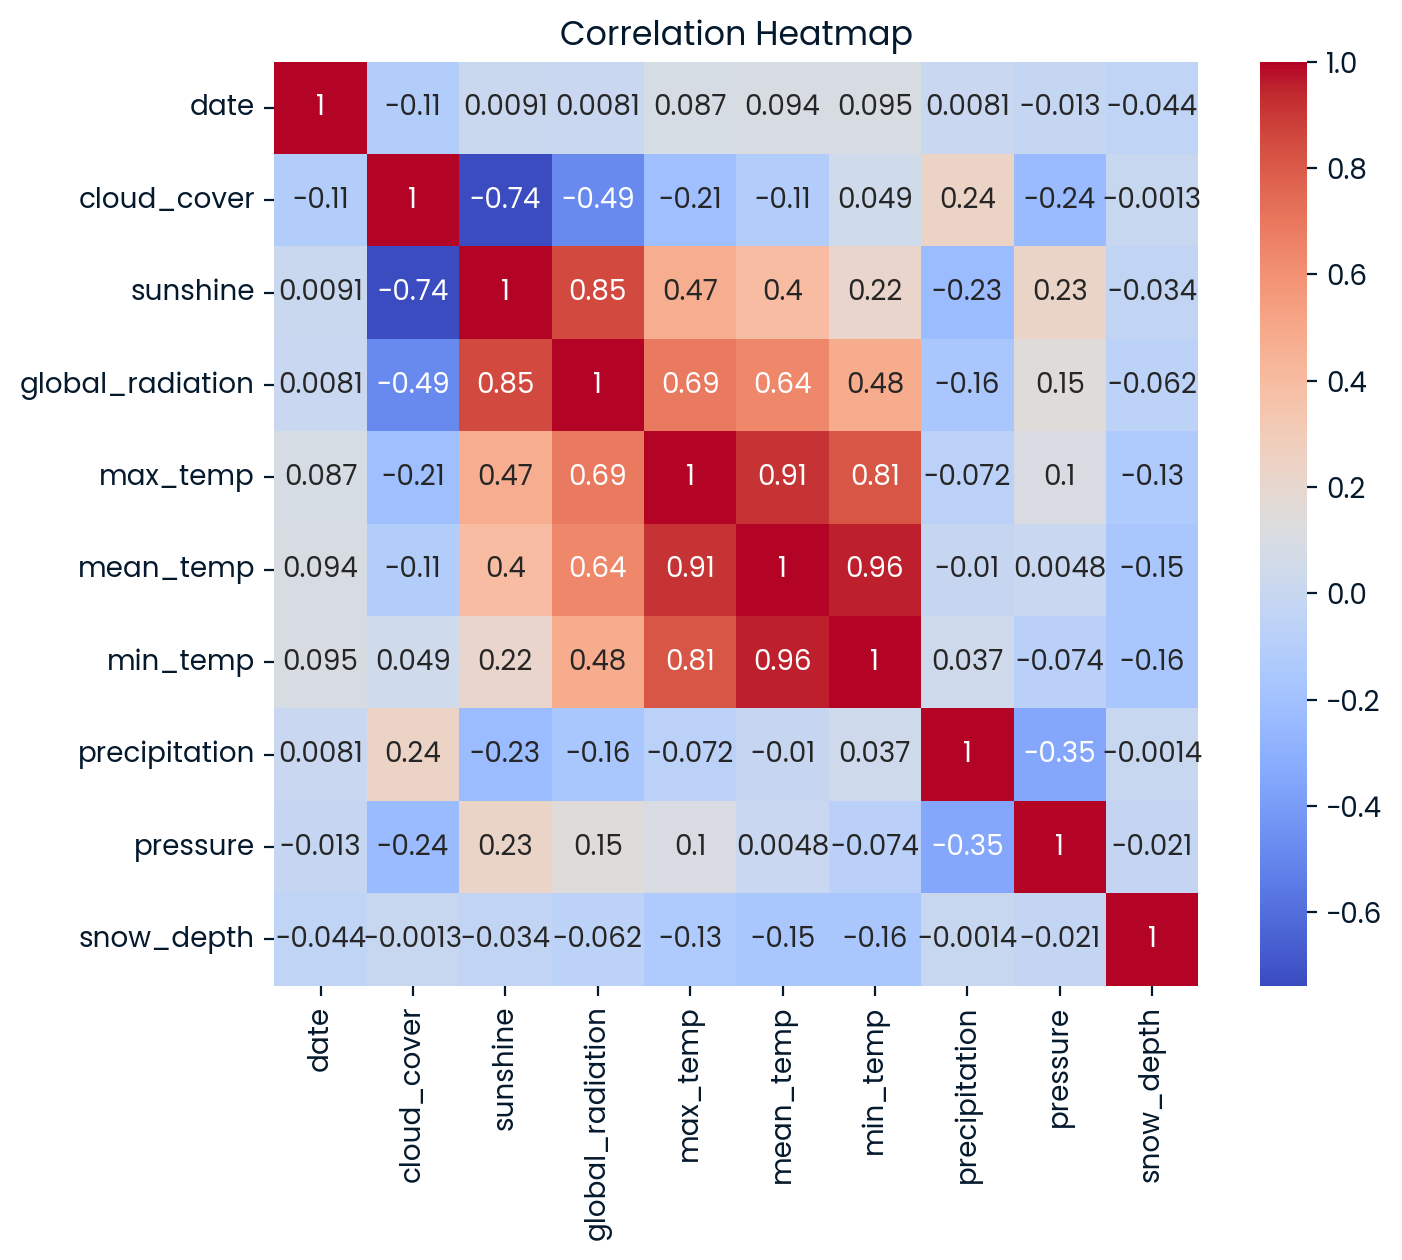

In [27]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# We only choose the features with correlation > 0.1
x_new = weather[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'snow_depth']]
# consider highly correlated parameter
x_new['cloud_cover x sunshine'] = weather['cloud_cover'] * weather['sunshine']
x_new['min x max'] = weather['min_temp'] * weather['max_temp']
x_new['global_radiation x sunshine'] = weather['global_radiation'] * weather['sunshine']

In [29]:
print(x_new)

       cloud_cover  sunshine  ...  min x max  global_radiation x sunshine
0              2.0       7.0  ...     -17.25                        364.0
1              6.0       1.7  ...     -12.00                         45.9
2              5.0       0.0  ...      -9.36                          0.0
3              8.0       0.0  ...       1.95                          0.0
4              6.0       2.0  ...      -7.84                         58.0
...            ...       ...  ...        ...                          ...
15336          1.0       0.9  ...      57.00                         28.8
15337          7.0       3.7  ...      -4.68                        140.6
15338          7.0       0.0  ...       4.51                          0.0
15339          6.0       0.4  ...      -0.56                          8.8
15340          7.0       1.3  ...      -4.65                         44.2

[15341 rows x 9 columns]


In [30]:
y = y.to_numpy().reshape(-1,1)
x_train_new, x_test_new, y_train, y_test = train_test_split(x_new, y, test_size=0.25, random_state=42)

In [31]:
#data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())                   # Standardize features
])

x_train_new_transformed = pipeline.fit_transform(x_train_new)
x_test_new_transformed = pipeline.transform(x_test_new)

imputer = SimpleImputer(strategy='mean') 
y_train_transformed = imputer.fit_transform(y_train)
y_test_transformed = imputer.transform(y_test)

In [32]:
#logging
for idx, depth in enumerate([1, 2, 10]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        # Create models
        lin_reg = LinearRegression().fit(x_train_new_transformed, y_train_transformed)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth = depth).fit(x_train_new_transformed, y_train_transformed)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(x_train_new_transformed, y_train_transformed)
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(x_test_new_transformed)
        lin_reg_rmse = mean_squared_error(y_test_transformed, y_pred_lin_reg, squared=False)
        y_pred_tree_reg = tree_reg.predict(x_test_new_transformed)
        tree_reg_rmse = mean_squared_error(y_test_transformed, y_pred_tree_reg, squared=False)
        y_pred_forest_reg = forest_reg.predict(x_test_new_transformed)
        forest_reg_rmse = mean_squared_error(y_test_transformed, y_pred_forest_reg, squared=False)
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)
 

In [33]:
experiment_results = mlflow.search_runs()
experiment_results

run_id  ...                            tags.mlflow.source.name
0   1e9cfa5056ef4a34ba8c26ac72d7eedc  ...  /usr/lib/python3/dist-packages/python_kernel/k...
1   25de0aa7bfb642ba87efa9bf86c5c315  ...  /usr/lib/python3/dist-packages/python_kernel/k...
2   43868e88383e453f95a931e59bee54d1  ...  /usr/lib/python3/dist-packages/python_kernel/k...
3   1d1baf67ac04428e8c08835ddb94181f  ...  /usr/lib/python3/dist-packages/python_kernel/k...
4   49abdf16f5834cf9928cfa49c0d0e98e  ...  /usr/lib/python3/dist-packages/python_kernel/k...
5   48dbad2c3d344e4f964dcec9bb9afa3f  ...  /usr/lib/python3/dist-packages/python_kernel/k...
6   1d6ccddf1f694088b3c416aa6ada44fc  ...  /usr/lib/python3/dist-packages/python_kernel/k...
7   a55915028f514ccebeac398fac6b473d  ...  /usr/lib/python3/dist-packages/python_kernel/k...
8   b0579c7a36f542c58386e68a73aadeda  ...  /usr/lib/python3/dist-packages/python_kernel/k...
9   b58bc0f940414a1687aef16ca93385dc  ...  /usr/lib/python3/dist-packages/python_kernel/k...
10  0a47ee5f240d4ae0877ad4eb978f489d  ...  /usr/lib/python3/dist-packages/python_kernel/k...
11  80e5e39f0b5d4649b4c2a1552cdd6b04  ...  /usr/lib/python3/dist-packages/python_kernel/k...
12  08f45e7002524476a06afd8c50d5b954  ...  /usr/lib/python3/dist-packages/python_kernel/k...
13  5ea6e4b4b42243d09d1f3e524b030096  ...  /usr/lib/python3/dist-packages/python_kernel/k...

[14 rows x 15 columns]